In [49]:
import numpy as np
from numpy import mean, std, dstack
import pandas as pd
from pandas import read_csv
from matplotlib import pyplot as plt
import keras
from keras.utils import to_categorical

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Input, Dropout, Flatten, BatchNormalization, GRU, Bidirectional
from tensorflow.keras.layers import concatenate, Dropout
from tensorflow.keras import optimizers
from keras.optimizers import Adam

import zipfile
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [50]:
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values
 

def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    loaded = dstack(loaded)
    return loaded
 
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    filenames = list()
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    X = load_group(filenames, filepath)
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

def load_dataset(prefix=''):
    trainX, trainy = load_dataset_group('train', prefix + 'HAR/')
    testX, testy = load_dataset_group('test', prefix + 'HAR/')
    trainy = trainy - 1
    testy = testy - 1
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print("trainX shape: ",trainX.shape)
    print("trainy shape: ", trainy.shape)
    print("testX shape: ", testX.shape)
    print("testy shape: ", testy.shape)
    return trainX, trainy, testX, testy

In [51]:
trainX, trainy, testX, testy = load_dataset('data/')

trainX shape:  (7352, 128, 9)
trainy shape:  (7352, 6)
testX shape:  (2947, 128, 9)
testy shape:  (2947, 6)


In [52]:
batch_size = 32
validation_split = 0.2

In [53]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(Bidirectional(GRU(64, input_shape=(n_timesteps,n_features), return_sequences=True)))
model.add(Bidirectional(GRU(32)))
model.add(BatchNormalization())
model.add(Dense(16))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(n_outputs, activation='softmax'))

In [54]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

In [55]:
train_epochs = 20
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/20
184/184 [==============================] - 45s 173ms/step - loss: 0.6212 - accuracy: 0.7670 - val_loss: 0.1565 - val_accuracy: 0.9286
Epoch 2/20
184/184 [==============================] - 32s 173ms/step - loss: 0.2447 - accuracy: 0.9128 - val_loss: 0.2224 - val_accuracy: 0.8960
Epoch 3/20
184/184 [==============================] - 31s 168ms/step - loss: 0.1810 - accuracy: 0.9347 - val_loss: 0.2509 - val_accuracy: 0.9191
Epoch 4/20
184/184 [==============================] - 33s 180ms/step - loss: 0.1762 - accuracy: 0.9344 - val_loss: 0.2070 - val_accuracy: 0.9130
Epoch 5/20
184/184 [==============================] - 34s 185ms/step - loss: 0.1780 - accuracy: 0.9332 - val_loss: 0.2424 - val_accuracy: 0.9252
Epoch 6/20
184/184 [==============================] - 31s 169ms/step - loss: 0.1592 - accuracy: 0.9410 - val_loss: 0.2485 - val_accuracy: 0.9327
Epoch 7/20
184/184 [==============================] - 33s 179ms/step - loss: 0.1589 - accuracy: 0.9366 - val_loss: 0.2110 - val_ac

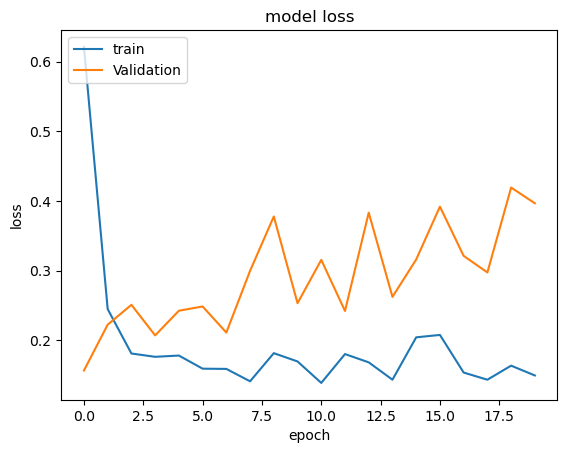

In [56]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [57]:
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the BiGRU model", test_accuracy)
predictions=model.predict(testX)

Accuracy of the BiGRU model 0.898201584815979
93/93 [==============================] - 5s 39ms/step


In [58]:
predictions

array([[5.21013668e-08, 8.84743940e-08, 8.71158079e-09, 9.73089505e-03,
        9.90268946e-01, 1.28129756e-08],
       [1.05830622e-07, 2.35556161e-08, 4.67373873e-09, 3.57210375e-02,
        9.64278877e-01, 1.43594905e-08],
       [9.23512573e-08, 1.91416945e-08, 4.48503634e-09, 3.55303809e-02,
        9.64469552e-01, 1.20123813e-08],
       ...,
       [4.57721990e-06, 9.99981403e-01, 1.40195889e-05, 2.83539348e-09,
        2.90015514e-08, 1.59881747e-10],
       [4.18237960e-07, 9.99992013e-01, 7.61606225e-06, 1.26525498e-10,
        3.98495192e-09, 4.81364341e-12],
       [7.70747306e-08, 9.99994397e-01, 5.53243763e-06, 4.29339272e-11,
        1.47394241e-09, 1.80116891e-12]], dtype=float32)

In [59]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y]

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

**** Confusion Matrix ****
[[468   4  23   1   0   0]
 [ 27 428  16   0   0   0]
 [  9   0 411   0   0   0]
 [  0   2   0 419  69   1]
 [  1   0   0 120 411   0]
 [  0  25   0   1   1 510]]
**** Classification Report ****
              precision    recall  f1-score   support

     Walking       0.93      0.94      0.94       496
      Walkup       0.93      0.91      0.92       471
    Walkdown       0.91      0.98      0.94       420
     Sitting       0.77      0.85      0.81       491
    Standing       0.85      0.77      0.81       532
      Laying       1.00      0.95      0.97       537

    accuracy                           0.90      2947
   macro avg       0.90      0.90      0.90      2947
weighted avg       0.90      0.90      0.90      2947



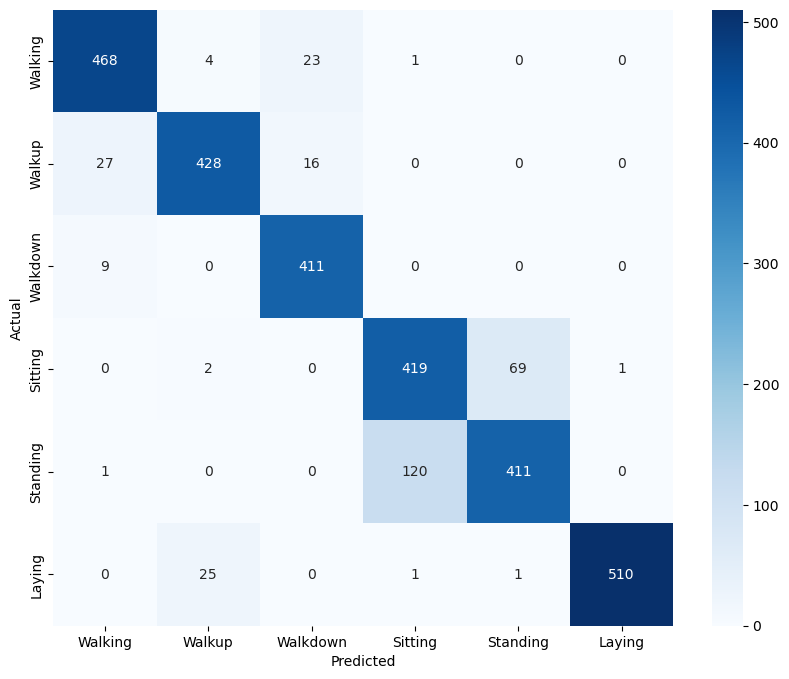

In [60]:
classNames=["Walking","Walkup","Walkdown","Sitting","Standing","Laying"]
display_results(testy,predictions,classNames)